## 1. Priprema Dataset-a
### 1.1 Ucitavanje Dataset-ova

**DocumentType** = Article, Article in Press, Review, Book Chapter, Letter, Note

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as stats
import pickle

from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram

from unidecode import unidecode
from collections import Counter
from operator import itemgetter

In [44]:
authorsPath = "data/autori.xlsx"
epidemiologyPath = "data/epidemiologija.xlsx"
immunologyPath = "data/imunologija.xlsx"
infectiveDiseasesPath = "data/infektivne_bolesti.xlsx"
microbiologyPath = "data/mikrobiologija.xlsx"

authorsData = pd.read_excel(authorsPath)

epidemiologyData = pd.read_excel(epidemiologyPath)
immunologyData = pd.read_excel(immunologyPath)
infectiveDiseasesData = pd.read_excel(infectiveDiseasesPath)
microbiologyData = pd.read_excel(microbiologyPath)

documentTypeSet = {"Article", "Article in Press", "Review", "Book Chapter", "Letter", "Note"}

duplicatesSubset = ['Authors', 'Title', 'Year', 'Source title', 'Document Type']


print(f"Autori - Rows: {authorsData.shape[0]} - Cols: {authorsData.shape[1]}")

print(f"Epidemologija - Rows: {epidemiologyData.shape[0]} - Cols: {epidemiologyData.shape[1]}")
print(f"Imunologija - Rows: {immunologyData.shape[0]} - Cols: {immunologyData.shape[1]}")
print(f"Infektivne bolesti - Rows: {infectiveDiseasesData.shape[0]} - Cols: {infectiveDiseasesData.shape[1]}")
print(f"Mikrobiologija - Rows: {microbiologyData.shape[0]} - Cols: {microbiologyData.shape[1]}")

# Global helper functions

def convertSerbianCharsToAscii(df, columns):
    serbianLatinCharsMap = {
        'ć': 'c',
        'č': 'c',
        'đ': 'dj',
        'š': 's',
        'ž': 'z',
        
        'Ć': 'C',
        'Č': 'C',
        'Đ': 'Dj',
        'Š': 'S',
        'Ž': 'Z',
    }
    
    for column in columns:
        df[column] = df[column].apply(lambda x: unidecode(x,  errors='strict'))


Autori - Rows: 59 - Cols: 5
Epidemologija - Rows: 673 - Cols: 15
Imunologija - Rows: 368 - Cols: 15
Infektivne bolesti - Rows: 273 - Cols: 15
Mikrobiologija - Rows: 661 - Cols: 15


### 1.2 Primerma Dataset-a sa Autorima
Primeceni su autori ciji je broj **Broj radova** i **H-indeks** null ili nepoznat.
**Broj radova** - cemo staviti da je 0, a posle cemo pokusati da ga dopinimo iz dataset-a za odgovarajucu katedru
**H-indeks** - cemo staviti da je 0

**Kratko ime** - dodata je i nova kolona, koja predstavlja kratko ime



In [45]:
authorsData.fillna(0, inplace=True)
authorsData['H indeks'] = authorsData['H indeks'].replace('?', 0)
authorsData = authorsData.astype({'H indeks': int, 'Broj radova': int})

convertSerbianCharsToAscii(authorsData, ['Ime', 'Prezime', 'Katedra'])

authorsData.insert(0,'id_author',0)
authorsData['id_author'] = authorsData.reset_index().index + 1

authorsData['Ime'] = authorsData['Ime'].apply(lambda x: x.strip())
authorsData['Prezime'] = authorsData['Prezime'].apply(lambda x: x.strip().replace('-', ' '))


authorsData['Kratko ime'] = authorsData['Prezime'] + ' ' + authorsData['Ime'].str[0] + '.'


# duplicatedAuthors = authorsData.duplicated(subset=['Ime', 'Prezime'])

# print(duplicatedAuthors)

print(authorsData.dtypes)

# print(authorsData['Kratko ime'])

print(authorsData['Kratko ime'].is_unique)

# print(authorsData)

authorsData.head(-1)

authorsData.to_excel("data/authorsData.xlsx") 

id_author       int64
Ime            object
Prezime        object
Katedra        object
H indeks        int32
Broj radova     int32
Kratko ime     object
dtype: object
True


## 1.3 Priprema Dataset-ova sa radovima
* Izbaceni Serbian Latin karakteri
* Dodata kolona 'Department name'
* Izbacene sledece kolne koje nisu od znacaja 'Art. No.', 'Page start', 'Page end', 'Page count', 'Link', 'Source', 'Volume', 'Issue'
* Isfiltrirani radovi po 'Document Type' ("Article", "Article in Press", "Review", "Book Chapter", "Letter", "Note").
* Izbaceni dupkiati - Rad se smatra dupliaktom ukoliko su mu kolone 'Authors', 'Title', 'Year', 'Source title' jednake.

### 1.3.1 Priprema Dataset-a za Epidemologiju

In [4]:
epidemiologyDataFiltered = epidemiologyData.copy(deep=True)

# Replacing Serbian Latin specific chars with Ascii chars

convertSerbianCharsToAscii(epidemiologyDataFiltered, ['Author', 'Authors', 'Title', 'Source title'])

# Adding 'Department name' column

epidemiologyDataFiltered['Research area'] = 'Epidemiology'

# Removing unnecessary charactes from 'Author' and 'Authors' columns

epidemiologyDataFiltered['Author'] = epidemiologyDataFiltered['Author'].apply(lambda x: x.strip().replace('-', ' '))
epidemiologyDataFiltered['Authors'] = epidemiologyDataFiltered['Authors'].apply(lambda x: x.strip().replace('-', ' '))


# Drop unnecessary columns
epidemiologyDataFiltered.drop(columns=['Art. No.'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Page start'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Page end'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Page count'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Link'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Source'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Volume'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Issue'], inplace=True)

# Replacing NaN Values

epidemiologyDataFiltered['Cited by'] = epidemiologyDataFiltered['Cited by'].fillna(0)

# Fixing types
epidemiologyDataFiltered = epidemiologyDataFiltered.astype(
    {
        'Year': int, 
        'Cited by': int
    }
)
print(epidemiologyDataFiltered.dtypes)

# Filtering rows by 'Documnet Type'

epidemiologyDataFiltered = epidemiologyDataFiltered[epidemiologyDataFiltered['Document Type'].isin(documentTypeSet)]


# Checking duplcates and dropping them
epidemiologyDataCountOld = epidemiologyDataFiltered.shape[0]

epidemiologyDataFiltered = epidemiologyDataFiltered.drop_duplicates(
    subset=duplicatesSubset,
    keep="first",
    inplace=False
)

epidemiologyDataCountNew = epidemiologyDataFiltered.shape[0]

print(f"Broj redova pre uklanjanja dupliata '{epidemiologyDataCountOld}'")
print(f"Broj redova posle uklanjanja dupliata '{epidemiologyDataCountNew}'")
print(f"Ukupno uklonjeno '{epidemiologyDataCountOld - epidemiologyDataCountNew}' naucnih radova")

epidemiologyDataFiltered.head(20)

Author           object
Authors          object
Title            object
Year              int32
Source title     object
Cited by          int32
Document Type    object
Research area    object
dtype: object
Broj redova pre uklanjanja dupliata '665'
Broj redova posle uklanjanja dupliata '514'
Ukupno uklonjeno '151' naucnih radova


,Author,Authors,Title,Year,Source title,Cited by,Document Type,Research area
0,Ljiljana Markovic Denic,"Birgand G., Mutters N.T., Ahmad R., Tacconelli...",Risk perception of the antimicrobial resistanc...,2020,Antimicrobial Resistance and Infection Control,0,Article,Epidemiology
1,Ljiljana Markovic Denic,"Djuric O., Markovic Denic L., Popovac S., Todo...",Awareness and knowledge about HPV infection an...,2020,Journal of B.U.ON.,0,Article,Epidemiology
2,Ljiljana Markovic Denic,"Radinovic K., Markovic Denic L., Milan Z., Cir...","Impact of intraoperative blood pressure, blood...",2019,Injury,5,Article,Epidemiology
3,Ljiljana Markovic Denic,"Djuric O., Markovic Denic L., Jovanovic B., Bu...",High incidence of multiresistant bacterial iso...,2019,Acta Microbiologica et Immunologica Hungarica,0,Article,Epidemiology
4,Ljiljana Markovic Denic,"Selakovic I., Dubljanin Raspopovic E., Markovi...",Can early assessment of hand grip strength in ...,2019,PLoS ONE,4,Article,Epidemiology
5,Ljiljana Markovic Denic,"Djuric O., Markovic Denic L., Jovanovic B., Jo...",Bacterial bloodstream infections in level-i tr...,2018,Journal of Infection in Developing Countries,0,Article,Epidemiology
6,Ljiljana Markovic Denic,"Ricchizzi E., Latour K., Karki T., Buttazzi R....",Antimicrobial use in european long-term care f...,2018,Eurosurveillance,12,Article,Epidemiology
7,Ljiljana Markovic Denic,"Plachouras D., Karki T., Hansen S., Hopkins S....",Antimicrobial use in european acute care hospi...,2018,Eurosurveillance,18,Article,Epidemiology
8,Ljiljana Markovic Denic,"Djuric O., Markovic Denic L., Jovanovic B., Bu...",Agreement between CDC/NHSN surveillance defini...,2018,PLoS ONE,2,Article,Epidemiology
9,Ljiljana Markovic Denic,"Jovanovic B., Djuric O., Markovic Denic L., Is...",Prognostic value of presepsin (Soluble CD14-su...,2018,Vojnosanitetski Pregled,0,Article,Epidemiology


### 1.3.2 Priprema Dataset-a za Imunologiju

In [5]:
immunologyDataFiltered = immunologyData.copy(deep=True)

# Replacing Serbian Latin specific chars with Ascii chars

convertSerbianCharsToAscii(immunologyDataFiltered, ['Author', 'Authors', 'Title', 'Source title'])

# Adding 'Department name' column

immunologyDataFiltered['Research area'] = 'Immunology'

# Removing unnecessary charactes from 'Author' and 'Authors' columns

immunologyDataFiltered['Author'] = immunologyDataFiltered['Author'].apply(lambda x: x.strip().replace('-', ' '))
immunologyDataFiltered['Authors'] = immunologyDataFiltered['Authors'].apply(lambda x: x.strip().replace('-', ' '))

# Drop unnecessary columns
immunologyDataFiltered.drop(columns=['Art. No.'], inplace=True)
immunologyDataFiltered.drop(columns=['Page start'], inplace=True)
immunologyDataFiltered.drop(columns=['Page end'], inplace=True)
immunologyDataFiltered.drop(columns=['Page count'], inplace=True)
immunologyDataFiltered.drop(columns=['Link'], inplace=True)
immunologyDataFiltered.drop(columns=['Source'], inplace=True)
immunologyDataFiltered.drop(columns=['Volume'], inplace=True)
immunologyDataFiltered.drop(columns=['Issue'], inplace=True)


# Replacing NaN Values

immunologyDataFiltered['Cited by'] = immunologyDataFiltered['Cited by'].fillna(0)

# Fixing types
immunologyDataFiltered = immunologyDataFiltered.astype(
    {
        'Year': int, 
        'Cited by': int
    }
)
print(immunologyDataFiltered.dtypes)

# Filtering rows by 'Documnet Type'

immunologyDataFiltered = immunologyDataFiltered[immunologyDataFiltered['Document Type'].isin(documentTypeSet)]


# Checking duplcates and dropping them
immunologyDataCountOld = immunologyDataFiltered.shape[0]

immunologyDataFiltered = immunologyDataFiltered.drop_duplicates(
    subset=duplicatesSubset,
    keep="first",
    inplace=False
)

immunologyDataCountNew = immunologyDataFiltered.shape[0]

print(f"Broj redova pre uklanjanja dupliata '{immunologyDataCountOld}'")
print(f"Broj redova posle uklanjanja dupliata '{immunologyDataCountNew}'")
print(f"Ukupno uklonjeno '{immunologyDataCountOld - immunologyDataCountNew}' naucnih radova")
print(f"Title unique: {immunologyDataFiltered['Title'].is_unique}")

immunologyDataFiltered.head(20)

Author           object
Authors          object
Title            object
Year              int32
Source title     object
Cited by          int32
Document Type    object
Research area    object
dtype: object
Broj redova pre uklanjanja dupliata '344'
Broj redova posle uklanjanja dupliata '272'
Ukupno uklonjeno '72' naucnih radova
Title unique: False


,Author,Authors,Title,Year,Source title,Cited by,Document Type,Research area
0,Vera Pravica,"Paunovic V., Petrovic I.V., Milenkovic M., Jan...",Autophagy-independent increase of ATG5 express...,2018,Journal of Neuroimmunology,6,Article,Immunology
1,Vera Pravica,"Mijac D., Vukovic Petrovic I., Mijac V., Perov...",MDR1 gene polymorphisms are associated with ul...,2018,PLoS ONE,8,Article,Immunology
2,Vera Pravica,"Perovic V., Markovic M., Kravljaca M., Milosev...",Cytokine Gene Polymorphism Profiles in Kidney ...,2018,Archives of Medical Research,0,Article,Immunology
3,Vera Pravica,"Mijac D., Petrovic I.V., Djuranovic S., Perovi...",The polymorphism rs3024505 (C/T) downstream of...,2016,Tohoku Journal of Experimental Medicine,6,Article,Immunology
4,Vera Pravica,"Perovic D., Perovic V., Pravica V., Bonaci Nik...",Evaluation of cytokine genetic polymorphisms i...,2016,Immunology Letters,5,Article,Immunology
5,Vera Pravica,"Marek E., Momper J.D., Hines R.N., Takao C.M.,...",Prediction of warfarin dose in pediatric patie...,2016,Journal of Pediatric Pharmacology and Therapeu...,5,Article,Immunology
6,Vera Pravica,"Tosic Dragovic J., Popovic J., Djuric P., Jank...",Relative risk for cardiovascular morbidity in ...,2016,Canadian Journal of Physiology and Pharmacology,3,Article,Immunology
7,Vera Pravica,"Kravljaca M., Perovic V., Pravica V., Brkovic ...",The importance of MDR1 gene polymorphisms for ...,2016,European Journal of Pharmaceutical Sciences,11,Article,Immunology
8,Vera Pravica,"Popadic S., Savic E., Markovic M., Ramic Z., M...","TNF, IL12B, and IFNG gene polymorphisms in ser...",2015,Annals of Dermatology,7,Article,Immunology
9,Vera Pravica,"Bazzaz J.T., Amoli M.M., Taheri Z., Larijani B...",TNF-a and IFN-g gene variation and genetic sus...,2014,Journal of Diabetes and Metabolic Disorders,5,Article,Immunology


### 1.3.3 Priprema Dataset-a za Infektivne bolesti

In [6]:
infectiveDiseasesDataFiltered = infectiveDiseasesData.copy(deep=True)

# Replacing Serbian Latin specific chars with Ascii chars

convertSerbianCharsToAscii(infectiveDiseasesDataFiltered, ['Author', 'Authors', 'Title', 'Source title'])

# Adding 'Department name' column

infectiveDiseasesDataFiltered['Research area'] = 'Infective Diseases'

# Removing unnecessary charactes from 'Author' and 'Authors' columns

infectiveDiseasesDataFiltered['Author'] = infectiveDiseasesDataFiltered['Author'].apply(lambda x: x.strip().replace('-', ' '))
infectiveDiseasesDataFiltered['Authors'] = infectiveDiseasesDataFiltered['Authors'].apply(lambda x: x.strip().replace('-', ' '))

# Drop unnecessary columns
infectiveDiseasesDataFiltered.drop(columns=['Art. No.'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Page start'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Page end'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Page count'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Link'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Source'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Volume'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Issue'], inplace=True)


# Replacing NaN Values

infectiveDiseasesDataFiltered['Cited by'] = infectiveDiseasesDataFiltered['Cited by'].fillna(0)

# Fixing types

infectiveDiseasesDataFiltered = infectiveDiseasesDataFiltered.astype(
    {
        'Year': int, 
        'Cited by': int
    }
)
print(infectiveDiseasesDataFiltered.dtypes)

# Filtering rows by 'Documnet Type'

infectiveDiseasesDataFiltered = infectiveDiseasesDataFiltered[infectiveDiseasesDataFiltered['Document Type'].isin(documentTypeSet)]


# Checking duplcates and dropping them
infectiveDiseasesDataCountOld = infectiveDiseasesDataFiltered.shape[0]

infectiveDiseasesDataFiltered = infectiveDiseasesDataFiltered.drop_duplicates(
    subset=duplicatesSubset,
    keep="first",
    inplace=False
)

infectiveDiseasesDataCountNew = infectiveDiseasesDataFiltered.shape[0]

print(f"Broj redova pre uklanjanja dupliata '{infectiveDiseasesDataCountOld}'")
print(f"Broj redova posle uklanjanja dupliata '{infectiveDiseasesDataCountNew}'")
print(f"Ukupno uklonjeno '{infectiveDiseasesDataCountOld - infectiveDiseasesDataCountNew}' naucnih radova")

infectiveDiseasesDataFiltered.head(20)

Author           object
Authors          object
Title            object
Year              int32
Source title     object
Cited by          int32
Document Type    object
Research area    object
dtype: object
Broj redova pre uklanjanja dupliata '266'
Broj redova posle uklanjanja dupliata '152'
Ukupno uklonjeno '114' naucnih radova


,Author,Authors,Title,Year,Source title,Cited by,Document Type,Research area
0,Jasmina Simonovic Babic,"Chkhartishvili N., Holban T., Babic J.S., Alex...",State of viral hepatitis care in 16 countries ...,2019,Central European Journal of Public Health,0,Article,Infective Diseases
1,Jasmina Simonovic Babic,"Jordovic J., Simonovic Babic J., Gasic V., Kot...",IL-28B genotypes as predictors of long-term ou...,2019,Journal of Infection in Developing Countries,1,Article,Infective Diseases
2,Jasmina Simonovic Babic,"Jordovic J., Bojovic K., Simonovic Babic J., G...",Significance of UGT1A1*28 genotype in patients...,2019,Journal of Medical Biochemistry,2,Article,Infective Diseases
3,Jasmina Simonovic Babic,"Kowalska J.D., Bursa D., Gokengin D., Jilich D...",HIV health care providers are ready to introdu...,2018,HIV Medicine,2,Article,Infective Diseases
4,Jasmina Simonovic Babic,"Jordovic J., Bojovic K., Simonovic Babic J., G...",Significance of UGT1A1*28 Genotype in Patients...,2018,Journal of Medical Biochemistry,0,Article in Press,Infective Diseases
5,Jasmina Simonovic Babic,"Mitrovic N., Delic D., Markovic Denic L., Niko...",The prevalence and the risk factors for hepati...,2018,Journal of Infection in Developing Countries,1,Article,Infective Diseases
6,Jasmina Simonovic Babic,"Simonovic Babic J., Bojovic K., Delic D., Kata...",ANTIVIRAL TREATMENT OF HEPATITIS C IN SERBIAN ...,2016,Medicinski pregled,2,Article,Infective Diseases
7,Jasmina Simonovic Babic,"Mitrovic N., Delic D., Markovic Denic L., Jovi...",Seroprevalence and risk factors for hepatitis ...,2015,Digestive and Liver Disease,14,Article,Infective Diseases
8,Jasmina Simonovic Babic,"Simonovic Babic J., Bojovic K., Fabri M., Kost...",Boceprevir in genotype 1 chronic hepatitis C: ...,2015,Srpski Arhiv za Celokupno Lekarstvo,1,Article,Infective Diseases
9,Jasmina Simonovic Babic,"Popovic N., Stojkovic Svirtlih N., Simonovic B...",[The efficacy of lamivudine in the treatment o...,2011,Srpski arhiv za celokupno lekarstvo,0,Article,Infective Diseases


### 1.3.4 Priprema Dataset-a za Mikrobiologiju

In [7]:
microbiologyDataFiltered = microbiologyData.copy(deep=True)

# Replacing Serbian Latin specific chars with Ascii chars

convertSerbianCharsToAscii(microbiologyDataFiltered, ['Author', 'Authors', 'Title', 'Source title'])

# Adding 'Department name' column

microbiologyDataFiltered['Research area'] = 'Microbiology'

# Removing unnecessary charactes from 'Author' and 'Authors' columns

microbiologyDataFiltered['Author'] = microbiologyDataFiltered['Author'].apply(lambda x: x.strip().replace('-', ' '))
microbiologyDataFiltered['Authors'] = microbiologyDataFiltered['Authors'].apply(lambda x: x.strip().replace('-', ' '))

# Drop unnecessary columns
microbiologyDataFiltered.drop(columns=['Art. No.'], inplace=True)
microbiologyDataFiltered.drop(columns=['Page start'], inplace=True)
microbiologyDataFiltered.drop(columns=['Page end'], inplace=True)
microbiologyDataFiltered.drop(columns=['Page count'], inplace=True)
microbiologyDataFiltered.drop(columns=['Link'], inplace=True)
microbiologyDataFiltered.drop(columns=['Source'], inplace=True)
microbiologyDataFiltered.drop(columns=['Volume'], inplace=True)
microbiologyDataFiltered.drop(columns=['Issue'], inplace=True)


# Replacing NaN Values

microbiologyDataFiltered['Cited by'] = microbiologyDataFiltered['Cited by'].fillna(0)

# Fixing types

microbiologyDataFiltered = microbiologyDataFiltered.astype(
    {
        'Year': int, 
        'Cited by': int
    }
)
print(microbiologyDataFiltered.dtypes)

# Filtering rows by 'Documnet Type'

microbiologyDataFiltered = microbiologyDataFiltered[microbiologyDataFiltered['Document Type'].isin(documentTypeSet)]


# Checking duplcates and dropping them
microbiologyDataCountOld = microbiologyDataFiltered.shape[0]

microbiologyDataFiltered = microbiologyDataFiltered.drop_duplicates(
    subset=duplicatesSubset,
    keep="first",
    inplace=False
)

microbiologyDataCountNew = microbiologyDataFiltered.shape[0]

print(f"Broj redova pre uklanjanja dupliata '{microbiologyDataCountOld}'")
print(f"Broj redova posle uklanjanja dupliata '{microbiologyDataCountNew}'")
print(f"Ukupno uklonjeno '{microbiologyDataCountOld - microbiologyDataCountNew}' naucnih radova")

microbiologyDataFiltered.head(20)

Author           object
Authors          object
Title            object
Year              int32
Source title     object
Cited by          int32
Document Type    object
Research area    object
dtype: object
Broj redova pre uklanjanja dupliata '638'
Broj redova posle uklanjanja dupliata '386'
Ukupno uklonjeno '252' naucnih radova


,Author,Authors,Title,Year,Source title,Cited by,Document Type,Research area
0,Tanja Jovanovic,"Jakovljevic A., Nikolic N., Carkic J., Andric ...",Notch-a possible mediator between Epstein-Barr...,2020,Acta Odontologica Scandinavica,1,Article,Microbiology
1,Tanja Jovanovic,"Banko A.V., Lazarevic I.B., Karalic D.Z., Djuk...",The sequence analysis of Epstein-Barr virus EB...,2019,Medical Microbiology and Immunology,0,Article,Microbiology
2,Tanja Jovanovic,"Tasic D., Lazarevic I., Knezevic A., Tasic L.,...",The impact of environmental and behavioural co...,2018,Epidemiology and Infection,0,Article,Microbiology
3,Tanja Jovanovic,"Jakovljevic A., Knezevic A., Nikolic N., Solda...",Herpesviruses viral loads and levels of proinf...,2018,Oral Diseases,6,Article,Microbiology
4,Tanja Jovanovic,"Karalic D., Lazarevic I., Banko A., Cupic M., ...",Analysis of variability of urinary excreted JC...,2018,Journal of NeuroVirology,1,Article,Microbiology
5,Tanja Jovanovic,"Jakovljevic A., Andric M., Nikolic N., Coric V...",Levels of oxidative stress biomarkers and bone...,2018,International Endodontic Journal,10,Article,Microbiology
6,Tanja Jovanovic,"Radalj A., Nisavic J., Krnjaic D., Valcic M., ...",Detection and molecular characterization of eq...,2018,Acta Veterinaria Brno,1,Article,Microbiology
7,Tanja Jovanovic,"Canullo L., Pesce P., Botticelli D., Covani U....",What is the impact of Epstein-Barr Virus in pe...,2018,International Journal of Oral and Maxillofacia...,4,Article,Microbiology
8,Tanja Jovanovic,"Stamenkovic M., Knezevic A., Knezevic I., Kuzm...",High-risk human papilloma virus genotypes in c...,2016,Biologicals,4,Article,Microbiology
9,Tanja Jovanovic,"Banko A., Lazarevic I., Stevanovic G., Cirkovi...",Analysis of the variability of Epstein-Barr vi...,2016,Journal of Medical Biochemistry,0,Article,Microbiology


## 1.4 Kombinovanje Dataset-ova sa radovima


In [36]:
# Combining filtered epidemilogoy, immunology, infectiveDiseases and microbiology dataframes

combinedWorks = pd.concat(
    [
        epidemiologyDataFiltered,
        immunologyDataFiltered,
        infectiveDiseasesDataFiltered,
        microbiologyDataFiltered
        
    ], 
    ignore_index=True
)

combinedWorks = combinedWorks.drop_duplicates(
    subset=['Authors', 'Title', 'Year', 'Source title', 'Cited by', 'Document Type'],
    keep="first",
    inplace=False
)


combinedWorks.insert(0,'id_work',0)
combinedWorks['id_work'] = combinedWorks.reset_index().index + 1

combinedWorks.drop(columns=['Author'], inplace=True)



print(f"Kombinovani dataset - Rows: {combinedWorks.shape[0]} - Cols: {combinedWorks.shape[1]}")
print(combinedWorks.dtypes)

combinedWorks.to_excel("data/combinedWorks.xlsx") 

combinedWorks.head(20)

# combinedWorks.groupby('Source title').size().reset_index(name='Num of work per Soruce title').sort_values(by='Num of work per Soruce title', ascending=False).head(50)



Kombinovani dataset - Rows: 1265 - Cols: 8
id_work           int64
Authors          object
Title            object
Year              int32
Source title     object
Cited by          int32
Document Type    object
Research area    object
dtype: object


,id_work,Authors,Title,Year,Source title,Cited by,Document Type,Research area
0,1,"Birgand G., Mutters N.T., Ahmad R., Tacconelli...",Risk perception of the antimicrobial resistanc...,2020,Antimicrobial Resistance and Infection Control,0,Article,Epidemiology
1,2,"Djuric O., Markovic Denic L., Popovac S., Todo...",Awareness and knowledge about HPV infection an...,2020,Journal of B.U.ON.,0,Article,Epidemiology
2,3,"Radinovic K., Markovic Denic L., Milan Z., Cir...","Impact of intraoperative blood pressure, blood...",2019,Injury,5,Article,Epidemiology
3,4,"Djuric O., Markovic Denic L., Jovanovic B., Bu...",High incidence of multiresistant bacterial iso...,2019,Acta Microbiologica et Immunologica Hungarica,0,Article,Epidemiology
4,5,"Selakovic I., Dubljanin Raspopovic E., Markovi...",Can early assessment of hand grip strength in ...,2019,PLoS ONE,4,Article,Epidemiology
5,6,"Djuric O., Markovic Denic L., Jovanovic B., Jo...",Bacterial bloodstream infections in level-i tr...,2018,Journal of Infection in Developing Countries,0,Article,Epidemiology
6,7,"Ricchizzi E., Latour K., Karki T., Buttazzi R....",Antimicrobial use in european long-term care f...,2018,Eurosurveillance,12,Article,Epidemiology
7,8,"Plachouras D., Karki T., Hansen S., Hopkins S....",Antimicrobial use in european acute care hospi...,2018,Eurosurveillance,18,Article,Epidemiology
8,9,"Djuric O., Markovic Denic L., Jovanovic B., Bu...",Agreement between CDC/NHSN surveillance defini...,2018,PLoS ONE,2,Article,Epidemiology
9,10,"Jovanovic B., Djuric O., Markovic Denic L., Is...",Prognostic value of presepsin (Soluble CD14-su...,2018,Vojnosanitetski Pregled,0,Article,Epidemiology


## 2 Istraživačka pitanja i ciljevi
### 2.1 Statistička obrada podataka (5 poena)

#### 1. Koliki je broj radova po svakom autoru? Koristiti i celovito i frakciono brojanje. Ko su najproduktivniji naučnici iz oblasti istraživanja i kojoj katedri pripadaju?

In [38]:
# 1. Koliki je broj radova po svakom autoru? Koristiti i celovito i frakciono brojanje. 
# Ko su najproduktivniji naučnici iz oblasti istraživanja i kojoj katedri pripadaju?


# Razdvajanje grupa autora u zasebne redove
workPerAuthor = combinedWorks.assign(Authors=combinedWorks['Authors'].str.split(',')).explode('Authors')
workPerAuthor.rename(columns={'Authors': 'Author'}, inplace=True)
workPerAuthor['Author'] = workPerAuthor['Author'].apply(lambda x: x.strip())

def f(x, kratko_ime):
    if kratko_ime in x:
        return kratko_ime
    else:
        return x


for index, row in authorsData.iterrows():
    workPerAuthor['Author'] = workPerAuthor['Author'].apply(f, kratko_ime=row['Kratko ime'])

workPerAuthor.to_excel("data/workPerAuthor.xlsx") 

# Joined authorsData and workPerAuthor

authorsAndWorks = pd.merge(authorsData, workPerAuthor, left_on='Kratko ime', right_on='Author', how='inner')

authorsAndWorks.to_excel("data/authorsAndWorks.xlsx") 


In [10]:
# Calacualte number of works per Author by workPerAuthor DataFrame and join with authorsData DataFrame

numOfWorksPerAuthor = workPerAuthor.groupby('Author').size().reset_index(name='Num of works per Author').sort_values(by='Num of works per Author', ascending=False)
    
numOfWorksPerAuthor.to_excel("data/workPerAuthorSredjeno.xlsx")


combineAuthorsAndNumOfWorks = pd.merge(numOfWorksPerAuthor, authorsData, left_on='Author', right_on='Kratko ime', how='inner')
combineAuthorsAndNumOfWorks.to_excel("data/prvoPitanje.xlsx")
# Prikazivanje rezultata

# combineAuthorsAndNumOfWorks.sort_values(by='Num of works per Author', ascending=False).head(6)


# Prikazivanje rezultata
# rezultat.head(80)

#### 2. Koliki je prosečan broj koautora po svakom autoru?

In [11]:
# id_work, Authors, Title, Year, Soruce title, Cited by, Document Type, Research area


numOfAuthorsPerWork = workPerAuthor.groupby('id_work').size().reset_index(name='Num of authors per Work')
# numOfAuthorsPerWork.head(5)


numOfWorksPerAuthor = authorsAndWorks.groupby('Author').size().reset_index(name='Num of works per Author').sort_values(by='Num of works per Author', ascending=False)
# numOfWorksPerAuthor.head(70)

result1 = pd.merge(numOfAuthorsPerWork, authorsAndWorks, on='id_work', how='inner')
# result1.head(70)

result2 = pd.merge(result1, numOfWorksPerAuthor, on='Author', how='inner')
# result.head(70)

result2 = result2.groupby('Author')['Num of authors per Work'].sum().reset_index(name='Sum of Co Authors')
# result2.head(70)

result2 = pd.merge(result2, numOfWorksPerAuthor, on='Author', how='inner')
# result2.head(70)

result2['AVG CoAuthors per Author'] = (result2['Sum of Co Authors'] - result2['Num of works per Author']) / result2['Num of works per Author']
result2.sort_values(by='Sum of Co Authors', ascending=False).head(70)



,Author,Sum of Co Authors,Num of works per Author,AVG CoAuthors per Author
8,Dubljanin E.,13907,37,374.864865
55,Vujcic I.,9286,27,342.925926
53,Trajkovic V.,4985,155,31.161290
1,Arsic Arsenijevic V.,4057,50,80.140000
51,Stanojevic M.,2238,66,32.909091
39,Pekmezovic T.,1996,270,6.392593
52,Stevanovic G.,1380,40,33.500000
31,Milosevic B.,664,38,16.473684
25,Markovic Denic L.,623,84,6.416667
43,Pravica V.,615,88,5.988636


#### 3.Na osnovu dostupnih podataka, odrediti H-indeks svakog od naučnika i uporediti ga sa dostupnim H-indeksom u datoteci autori.xlsx.?

In [12]:
# H-indeks nam se u velikoj meri poklapa u datoj excel tabeli autori.xlsx.

authorWorksCitedBy = {}
authorHIndeks = {}
for index, row in authorsData.iterrows():
    authorWorksCitedBy[row['Kratko ime']] = []

for index, row in authorsAndWorks.iterrows():
    authorWorksCitedBy[row['Kratko ime']].append(row['Cited by'])

for author in authorWorksCitedBy:
    authorWorksCitedBy[author].sort(reverse=True)

for author in authorWorksCitedBy:
    hIndeks = 0
    
    for index, item in enumerate(authorWorksCitedBy[author]):
        if item >= index + 1:
            hIndeks = index + 1
        else:
            break
    
    authorHIndeks[author] = hIndeks

authorsHIndex = pd.DataFrame(list(authorHIndeks.items()), columns=['Kratko ime', 'Izracunati H index'])

combinedAuthorsAndHIndex = pd.merge(authorsHIndex, authorsData, on='Kratko ime', how='inner')
combinedAuthorsAndHIndex.head(80)


,Kratko ime,Izracunati H index,id_author,Ime,Prezime,Katedra,H indeks,Broj radova
0,Jovanovic T.,11,1,Tanja,Jovanovic,Katedra za mikrobiologiju,11,45
1,Savic B.,10,2,Branislava,Savic,Katedra za mikrobiologiju,10,30
2,Mitrovic S.,4,3,Sanja,Mitrovic,Katedra za mikrobiologiju,4,20
3,Ranin L.,7,4,Lazar,Ranin,Katedra za mikrobiologiju,7,40
4,Arsic Arsenijevic V.,17,5,Valentina,Arsic Arsenijevic,Katedra za mikrobiologiju,17,52
5,Djukic S.,8,6,Slobodanka,Djukic,Katedra za mikrobiologiju,8,38
6,Cupic M.,7,7,Maja,Cupic,Katedra za mikrobiologiju,7,31
7,Vuckovic Opavski N.,0,8,Natasa,Vuckovic Opavski,Katedra za mikrobiologiju,1,3
8,Dzamic A.,5,9,Aleksandar,Dzamic,Katedra za mikrobiologiju,6,24
9,Vukovic D.,14,10,Dragana,Vukovic,Katedra za mikrobiologiju,14,45


#### 4. Koje katedre su najproduktivnije posmatrajući naučnu produkciju i citiranost u časopisima na osnovu dostupnih podataka?

In [13]:
citedByPerAuthor = authorsAndWorks.groupby('Kratko ime')['Cited by'].sum().reset_index(name='Sum of Cited by')
# citedByPerAuthor.head(80)

numOfWorksPerAuthor = authorsAndWorks.groupby('Kratko ime').size().reset_index(name='Num of works per Author')
# numOfWorksPerAuthor.head(80)

result = pd.merge(citedByPerAuthor, numOfWorksPerAuthor, on='Kratko ime', how='inner')
result = pd.merge(authorsData, result, on='Kratko ime', how='inner')

result = result.groupby('Katedra').agg({'Sum of Cited by':'sum','Num of works per Author':'sum'})
result.sort_values(by='Sum of Cited by', ascending=False).head(10)

,Sum of Cited by,Num of works per Author
Katedra,,
Katedra za mikrobiologiju,24960,650
Katedra za imunologiju,17509,356
Katedra za epidemiologiju,7862,706
Infektivne bolesti,2389,291


#### 5. U kojim godinama su autori bili najproduktivniji na nivou fakulteta i pojedinačnim
#### katedrama?

##### 5.1. Po nivou fakulteta

In [14]:
productivityPerYear = authorsAndWorks.groupby('Year').size().reset_index(name='Num of works')
productivityPerYear.sort_values(by='Num of works', ascending=False).head(100)

,Year,Num of works
33,2018,207
29,2014,181
30,2015,150
34,2019,143
31,2016,140
28,2013,140
32,2017,112
27,2012,99
35,2020,88
22,2007,82


##### 5.2. Po nivou katedre

In [15]:
productivityPerYearAndDeprtment = authorsAndWorks.groupby(['Year', 'Katedra']).size().reset_index(name='Num of works')
productivityPerYearAndDeprtment.sort_values(by=['Year', 'Num of works'], ascending=[False, False]).head(50)

,Year,Katedra,Num of works
111,2020,Katedra za epidemiologiju,44
110,2020,Infektivne bolesti,25
113,2020,Katedra za mikrobiologiju,17
112,2020,Katedra za imunologiju,2
107,2019,Katedra za epidemiologiju,53
106,2019,Infektivne bolesti,38
109,2019,Katedra za mikrobiologiju,38
108,2019,Katedra za imunologiju,14
105,2018,Katedra za mikrobiologiju,72
103,2018,Katedra za epidemiologiju,68


#### 6. U kojim časopisima se u proseku najviše objavljuje?

In [16]:
numOfWorlsPerArticle = authorsAndWorks.groupby(['Source title']).size().reset_index(name='Num of works')
numOfWorlsPerArticle.sort_values(by='Num of works', ascending=False).head(10)


,Source title,Num of works
47,Archives of Biological Sciences,86
493,Srpski arhiv za celokupno lekarstvo,73
318,Journal of Infection in Developing Countries,59
526,Vojnosanitetski Pregled,58
381,Medicinski pregled,53
492,Srpski Arhiv za Celokupno Lekarstvo,49
434,PLoS ONE,44
322,Journal of Medical Biochemistry,29
527,Vojnosanitetski pregled. Military-medical and ...,28
23,Acta chirurgica Iugoslavica,24


#### 7. Da li postoje razlike između katedri u smislu obima i učestanosti publikovanja u časopisima?
Iz zadtaka broj 6. se vidi da je casopis 'Archives of Biological Sciences' ima najvise publikacija, a na slici ispod vidimo da ne postoji preterano velikao oscilacija u smislu publikacija po casopisima od strane razlicitih katedri.

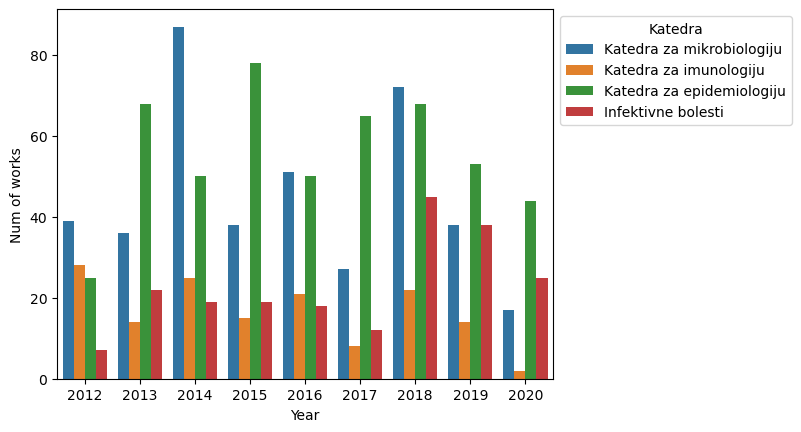

In [17]:
numOfWorksPerArticleAndDepartment = authorsAndWorks.groupby(['Source title', 'Year','Katedra']).size().reset_index(name='Num of works')
# numOfWorksPerArticleAndDepartment.sort_values(by='Year', ascending=False).head(70)


grafik = sns.barplot(
    data=productivityPerYearAndDeprtment.sort_values(by=['Year'], ascending=[False]).head(36),
    x='Year', 
    y='Num of works', 
    hue='Katedra'
)
sns.move_legend(grafik, "upper left", bbox_to_anchor=(1, 1))
plt.show()

#### 8. Da li postoji razlika u prosečnom broju autora po radovima u časopisima po katedrama?

In [18]:
numOfAuthorsPerDepartment = authorsData.groupby('Katedra').size().reset_index(name='Num of authors')
# numOfAuthorsPerDepartment.head(5)

numOfWorksPerDepratment = combineAuthorsAndNumOfWorks.groupby('Katedra')['Num of works per Author'].sum().reset_index(name='Num of works')
# numOfWorksPerDepratment.head(5)

result = pd.merge(numOfAuthorsPerDepartment, numOfWorksPerDepratment, on='Katedra', how='inner')

result['Author per work'] = result['Num of authors'] / result['Num of works']
result['AVG Author per work'] = result['Author per work'].mean()
result.head(5)



,Katedra,Num of authors,Num of works,Author per work,AVG Author per work
0,Infektivne bolesti,13,291,0.044674,0.031005
1,Katedra za epidemiologiju,13,706,0.018414,0.031005
2,Katedra za imunologiju,8,356,0.022472,0.031005
3,Katedra za mikrobiologiju,25,650,0.038462,0.031005


#### 9. Kakav je odnos broja koautora sa fakulteta u odnosu na broj autora van fakulteta po katedrama i na nivou celog fakulteta?

In [19]:
numOfDomesticAuthorsPerWork = authorsAndWorks.groupby(['id_work', 'Title']).size().reset_index(name='Num of domestic authors')
# numOfDomesticAuthorsPerWork.head(20)

foreginAuthorAndWorks = pd.merge(workPerAuthor, authorsData, left_on='Author', right_on='Kratko ime', how='left')
filtered_df = foreginAuthorAndWorks[foreginAuthorAndWorks['Author'].isin(authorsData['Kratko ime'])]
foreginAuthorAndWorks = foreginAuthorAndWorks.drop(filtered_df.index)
# foreginAuthorAndWorks.head(40)


numOfForeginAuthorsPerWork = foreginAuthorAndWorks.groupby(['id_work', 'Title']).size().reset_index(name='Num of foregin authors')
# numOfForeginAuthorsPerWork.head(40)


numOfForeginAndDomesitAuthorsPerWork = pd.merge(numOfDomesticAuthorsPerWork, numOfForeginAuthorsPerWork, on=['id_work', 'Title'])
# numOfForeginAndDomesitAuthorsPerWork.head(40)

mergedDomesticAuhorsWorksAndNumOfCoAuthors = pd.merge(authorsAndWorks, numOfForeginAndDomesitAuthorsPerWork, on='id_work', how='inner')
# result9.head(25)

noDuplicatedWorks = mergedDomesticAuhorsWorksAndNumOfCoAuthors[~mergedDomesticAuhorsWorksAndNumOfCoAuthors.duplicated(['id_work', 'Katedra'], keep=False)]
# df_no_duplicates.head(10)

groupbyDepartment = noDuplicatedWorks.groupby('Katedra')[['Num of domestic authors', 'Num of foregin authors']].sum()
groupbyDepartment['The ratio of domesti and foregin authors'] = groupbyDepartment['Num of domestic authors'] / groupbyDepartment['Num of foregin authors']

groupbyDepartment.head(5)



,Num of domestic authors,Num of foregin authors,The ratio of domesti and foregin authors
Katedra,,,
Infektivne bolesti,193,2206,0.087489
Katedra za epidemiologiju,504,11640,0.043299
Katedra za imunologiju,317,5262,0.060243
Katedra za mikrobiologiju,372,21055,0.017668


In [20]:
foreginAuthorAndWorks.groupby('Author').size().reset_index(name='Num of works per Author').sort_values(by='Num of works per Author', ascending=False).head(20)


,Author,Num of works per Author
3690,Hutchinson I.V.,59
2339,Drulovic J.,59
3977,Jevtovic D.,56
5458,Marinkovic J.,52
7792,Salemovic D.,46
4611,Kostic V.S.,44
728,Barac A.,44
8581,Stepanovic S.,43
8746,Svetel M.,43
3338,Haj Mirzaian A.,43


### 2.2 Osnovna karakterizacija modelovanih mreža (10 poena)

In [21]:
# TODO: Izvezi DataFrame 'authorsAndWorks' preko Pickle u fajl i ucitaj ga ovde
inputCleanData = authorsAndWorks

labels = set(inputCleanData['Kratko ime'].unique())
print(f"Postoji { len(labels) } različitih autora")

Postoji 58 različitih autora


In [22]:
reducedAuthorsAndWorks = inputCleanData[['id_work', 'Author']]


combinations_df = pd.merge(reducedAuthorsAndWorks, reducedAuthorsAndWorks, on='id_work')

# combinations_df.head(80)

# Filtriranje parova autora koji nisu isti (da ne bi došlo do parova autora sa samim sobom)
filtered_combinations_df = combinations_df[combinations_df['Author_x'] != combinations_df['Author_y']]

# Kreiranje novog DataFrame-a sa kolonama 'id_work', 'author' i 'co-author'
result_df = filtered_combinations_df[['id_work', 'Author_x', 'Author_y']].rename(columns={'Author_x': 'Author', 'Author_y': 'Co-Author'})

result_df.head(-1)



,id_work,Author,Co-Author
1,291,Jovanovic T.,Knezevic A.
2,291,Jovanovic T.,Pekmezovic T.
3,291,Knezevic A.,Jovanovic T.
5,291,Knezevic A.,Pekmezovic T.
6,291,Pekmezovic T.,Jovanovic T.
...,...,...,...
4401,916,Bojovic K.,Mitrovic N.
4402,916,Mitrovic N.,Bojovic K.
4405,917,Bojovic K.,Milosevic I.
4406,917,Milosevic I.,Bojovic K.


In [23]:
G = nx.Graph()
G.add_nodes_from(labels)

for _, idWork, author, coAuthor in result_df.itertuples():
    if (author, coAuthor) in G.edges:
        G.edges[author, coAuthor]['weight'] += 1
    else:
        G.add_edge(author, coAuthor, weight=1)

print(G.edges.data("weight"))

nx.write_gml(G, "models/mreza_jedan.gml")

[('Nikolic V.', 'Knezevic A.', 2), ('Nikolic V.', 'Stanojevic M.', 22), ('Nikolic V.', 'Trajkovic V.', 2), ('Nikolic V.', 'Ranin J.', 8), ('Nikolic V.', 'Kisic Tepavcevic D.', 2), ('Nikolic V.', 'Bojovic K.', 2), ('Vujcic I.', 'Mitrovic S.', 2), ('Vujcic I.', 'Dzamic A.', 4), ('Vujcic I.', 'Dubljanin E.', 38), ('Vujcic I.', 'Vukovic D.', 2), ('Vujcic I.', 'Sipetic Grujicic S.', 4), ('Vujcic I.', 'Maksimovic J.', 8), ('Vujcic I.', 'Nikolic A.', 2), ('Vujcic I.', 'Maksimovic N.', 4), ('Vujcic I.', 'Milosevic B.', 2), ('Vujcic I.', 'Stevanovic G.', 2), ('Vujcic I.', 'Pekmezovic T.', 2), ('Vujcic I.', 'Kisic Tepavcevic D.', 2), ('Vujcic I.', 'Gazibara T.', 2), ('Vujcic I.', 'Maric G.', 2), ('Vujcic I.', 'Marusic V.', 2), ('Pekmezovic T.', 'Jovanovic T.', 2), ('Pekmezovic T.', 'Knezevic A.', 4), ('Pekmezovic T.', 'Vukovic D.', 2), ('Pekmezovic T.', 'Markovic M.', 4), ('Pekmezovic T.', 'Jankovic M.', 6), ('Pekmezovic T.', 'Pravica V.', 2), ('Pekmezovic T.', 'Popadic D.', 4), ('Pekmezovic T.'

In [24]:
H = G.to_undirected()

print("Broj povezanih kompnenti: " , nx.number_connected_components(H))

connected_componnets = sorted(nx.connected_components(H), key=len, reverse=True)
print("Velicina povezanih komponenti:")
for x in connected_componnets:
    print(len(x) , "  ")
    
print( "Prosecni koeficijent klasterizacije: " , nx.average_clustering(H), ", Globalni koeficijent klasterizacije: " , nx.transitivity(H) )

Broj povezanih kompnenti:  1
Velicina povezanih komponenti:
58   
Prosecni koeficijent klasterizacije:  0.5569535644581753 , Globalni koeficijent klasterizacije:  0.4472295514511873


Max lokalni cc: 0.09200531258775885
Prosečan cc: 0.5569535644581753
Lokalni stepeni klasterisanja koji nisu nula:
                    Author        Cc
7              Markovic M.  0.012048
45              Nikolic A.  0.012838
8               Vukovic D.  0.016438
25              Perovic V.  0.016991
14            Trajkovic V.  0.017067
33     Sipetic Grujicic S.  0.017296
1                Vujcic I.  0.019203
42       Markovic Denic L.  0.019524
6           Stamenkovic M.  0.021617
15           Stevanovic G.  0.021681
3                 Ranin J.  0.022477
37           Maksimovic J.  0.022680
39           Maksimovic N.  0.022936
21             Mitrovic S.  0.024665
44               Dzamic A.  0.024781
35              Pravica V.  0.026412
17    Arsic Arsenijevic V.  0.026485
31                Mijac V.  0.026679
20             Knezevic A.  0.027172
2            Pekmezovic T.  0.027175
36     Vukovic Petrovic I.  0.027267
32            Lazarevic I.  0.027478
0               Nikolic V.  0.02747

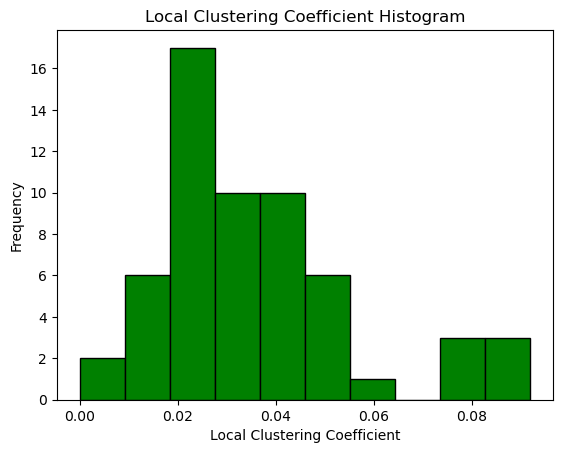

In [25]:
# Lokalni Stepen klasterizacije

author, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())

nenula = [(auth, cc)  for auth, cc in zip(author, clustering_coef) if cc > 0]

df = pd.DataFrame(nenula, columns = ["Author", "Cc"])
df.sort_values('Cc', inplace = True)

max_lokalni_stepen_klasterisanja = max(clustering_coef)

prosecni_stepen_klasterisanja = nx.average_clustering(G)

print(f"Max lokalni cc: {max_lokalni_stepen_klasterisanja}")
print(f"Prosečan cc: {prosecni_stepen_klasterisanja}")
print("Lokalni stepeni klasterisanja koji nisu nula:")
print(df)

# ax = df.plot.scatter(x='Author', y='Cc')
# ax.set_xscale("log")
# ax.set_yscale("log");


plt.hist(clustering_coef, bins=10, edgecolor='black', color = "green")

# Postavite naslove i oznake osa
plt.title('Local Clustering Coefficient Histogram')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')

plt.savefig('images/local_cc_main_network.png')
# Prikazivanje histograma
plt.show()


In [26]:
def plot_deg_frequency(G, weighted = False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
        
    _, deg_list = zip(*degrees)
    deg_counts = Counter(deg_list)        
    print(deg_counts)
    x, y = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()


Nodes: 58
Edges: 307
Counter({10: 9, 9: 7, 8: 7, 13: 7, 11: 6, 14: 6, 12: 6, 6: 4, 7: 2, 16: 2, 18: 1, 4: 1})


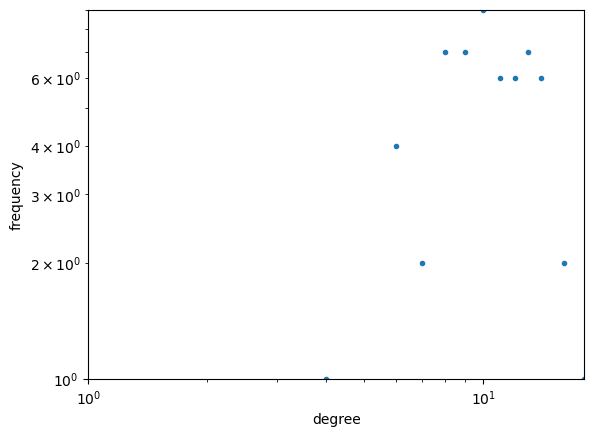

In [27]:
n = G.number_of_nodes()
m = G.number_of_edges()

print(f"Nodes: {n}")
print(f"Edges: {m}")

Gnm = nx.gnm_random_graph(n, m) 

# plot_deg_frequency(Gnm, xscale = 'linear', yscale = 'linear')
plot_deg_frequency(Gnm, xscale = 'log', yscale = 'log')

0.18572292800967938
Broj čvorova originalne mreže minus broj čvorova u ER mreži iznosi 33, što je odstupanje od 10.749185667752442%
Counter({8: 14, 10: 9, 7: 6, 12: 6, 11: 5, 14: 3, 5: 3, 13: 3, 9: 3, 6: 3, 16: 2, 4: 1})


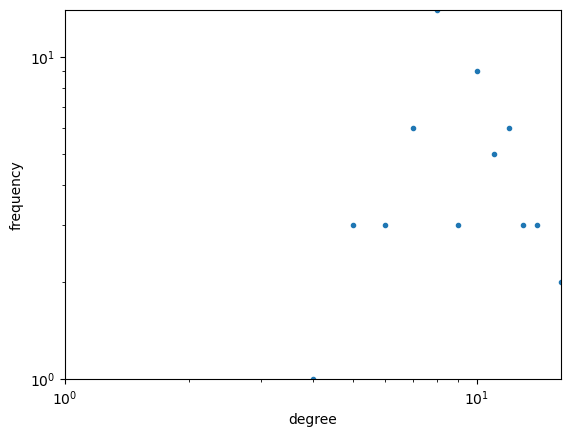

Max lokalni cc Erods-Reny mreze: 0.38095238095238093
Prosečan cc Erods-Reny mreze: 0.16885781842678396
Lokalni stepeni klasterisanja koji nisu nula Erods-Reny mreze:
    Author        Cc
23      23  0.066667
35      36  0.071429
16      16  0.071429
28      29  0.075758
31      32  0.088889
22      22  0.100000
9        9  0.107143
12      12  0.107143
29      30  0.107143
30      31  0.109890
44      45  0.111111
40      41  0.111111
50      51  0.125000
5        5  0.131868
54      55  0.133333
37      38  0.133333
25      26  0.136364
45      46  0.138889
24      25  0.142857
43      44  0.142857
32      33  0.142857
36      37  0.142857
4        4  0.145455
19      19  0.145455
47      48  0.145455
38      39  0.150000
11      11  0.151515
21      21  0.151515
20      20  0.153846
3        3  0.163636
18      18  0.166667
55      56  0.166667
15      15  0.166667
6        6  0.166667
39      40  0.177778
0        0  0.178571
14      14  0.178571
2        2  0.178571
13      13  0.1

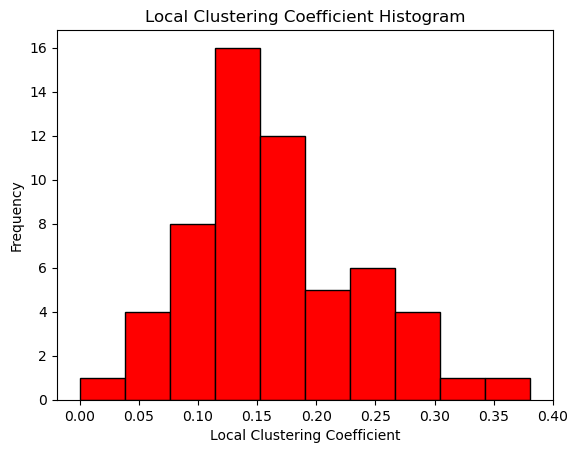

In [28]:
# Erdos-Renyi mreza N=58 (broj cvorova - autora)

p = ( 2*float(m) ) / ( n* (n-1) )
print(p)

er_mreza = nx.erdos_renyi_graph(n,p)


delta_m = m - er_mreza.number_of_edges()
print(f"Broj čvorova originalne mreže minus broj čvorova u ER mreži iznosi {delta_m}, što je odstupanje od {abs(float(delta_m)) * 100 / m}%")

# plot_deg_frequency(er_mreza, xscale = 'linear', yscale = 'linear')
plot_deg_frequency(er_mreza, xscale = 'log', yscale = 'log')


# Lokalni Stepen klasterizacije

author, clustering_coef = zip(*nx.clustering(er_mreza, weight = "weight").items())

nenula = [(auth, cc)  for auth, cc in zip(author, clustering_coef) if cc > 0]

df = pd.DataFrame(nenula, columns = ["Author", "Cc"])
df.sort_values('Cc', inplace = True)

max_lokalni_stepen_klasterisanja = max(clustering_coef)

prosecni_stepen_klasterisanja = nx.average_clustering(er_mreza)

print(f"Max lokalni cc Erods-Reny mreze: {max_lokalni_stepen_klasterisanja}")
print(f"Prosečan cc Erods-Reny mreze: {prosecni_stepen_klasterisanja}")
print("Lokalni stepeni klasterisanja koji nisu nula Erods-Reny mreze:")
print(df)

plt.hist(clustering_coef, bins=10, edgecolor='black', color = "red")

# Postavite naslove i oznake osa
plt.title('Local Clustering Coefficient Histogram')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')

plt.savefig('images/local_cc_er_network.png')

# Prikazivanje histograma
plt.show()

Max lokalni cc Random scale-free mreze: 0.3404521644800339
Prosečan cc Random scale-free mreze: 0.15143195642388285
Lokalni stepeni klasterisanja koji nisu nula Random scale-free mreze:
    Author        Cc
9       12  0.004762
0        0  0.021711
3        4  0.024182
1        1  0.050733
4        7  0.055780
2        2  0.065849
7       10  0.090072
15      47  0.100000
6        8  0.125992
8       11  0.200000
14      29  0.200000
10      13  0.209652
5        3  0.226480
11      20  0.270217
13      28  0.270217
12      22  0.340452


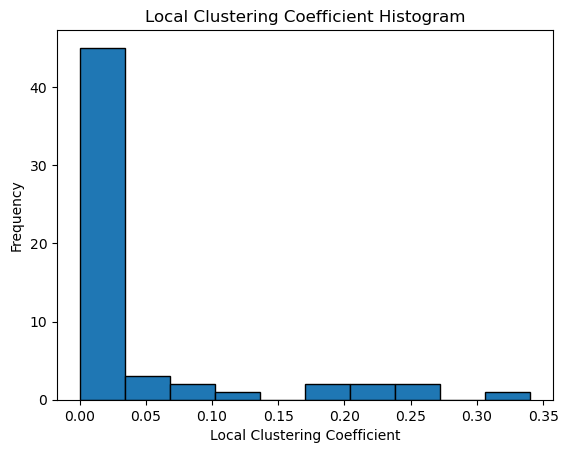

In [29]:
# Random generated ScaleFree network

scale_free_network = nx.scale_free_graph(n)

# create weighted graph from scale_free_network
Q = nx.DiGraph()
for u,v in scale_free_network.edges():
    if Q.has_edge(u,v):
        Q[u][v]['weight'] += 1
    else:
        Q.add_edge(u, v, weight=1)
        
# Lokalni Stepen klasterizacije

author, clustering_coef = zip(*nx.clustering(Q, weight = "weight").items())

nenula = [(auth, cc)  for auth, cc in zip(author, clustering_coef) if cc > 0]

df = pd.DataFrame(nenula, columns = ["Author", "Cc"])
df.sort_values('Cc', inplace = True)

max_lokalni_stepen_klasterisanja = max(clustering_coef)

prosecni_stepen_klasterisanja = nx.average_clustering(Q)

print(f"Max lokalni cc Random scale-free mreze: {max_lokalni_stepen_klasterisanja}")
print(f"Prosečan cc Random scale-free mreze: {prosecni_stepen_klasterisanja}")
print("Lokalni stepeni klasterisanja koji nisu nula Random scale-free mreze:")
print(df)


plt.hist(clustering_coef, bins=10, edgecolor='black')

# Postavite naslove i oznake osa
plt.title('Local Clustering Coefficient Histogram')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')

plt.savefig('images/local_cc_random_scale_free_network.png')

# Prikazivanje histograma
plt.show()



In [30]:
# Asortativnost
# asortativnost na osnovu netežinskog stepena čvora
r1 = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: {r1}")

# asortativnost na osnovu težinskog stepena čvora
r2 = nx.degree_assortativity_coefficient(G, weight='weight')
print(f"Koeficijent asortativnosti na osnovu težinskog stepena čvora: {r2}")



Koeficijent asortativnosti na osnovu netežinskog stepena čvora: -0.04122845538622359
Koeficijent asortativnosti na osnovu težinskog stepena čvora: -0.03255396785166119


In [31]:
# Rich club phenomenon; Havel-Hakimi algorithm

degrees = G.degree()
_, deg_list = zip(*degrees)
print(deg_list)

havel_hakimi_mreza = nx.havel_hakimi_graph(deg_list)

# nx.draw(havel_hakimi_mreza)

nx.write_gml(havel_hakimi_mreza, "models/havel_hakimi.gml")



(6, 15, 17, 8, 15, 4, 6, 30, 19, 10, 3, 11, 14, 16, 16, 22, 6, 7, 14, 7, 15, 9, 3, 8, 13, 9, 5, 8, 1, 12, 14, 15, 14, 21, 11, 7, 1, 12, 4, 12, 2, 13, 9, 9, 11, 12, 9, 12, 13, 12, 10, 9, 17, 3, 10, 8, 7, 8)


In [32]:
rich_club_coeffs = nx.rich_club_coefficient(G.to_undirected())
rich_club_coeffs_havel_hakimi = nx.rich_club_coefficient(havel_hakimi_mreza)

if rich_club_coeffs:
    degrees = list(rich_club_coeffs.keys())
    coefficients = list(rich_club_coeffs.values())
    print(degrees)
    print(coefficients)
    plt.plot(degrees, coefficients, marker='o')
    plt.xlabel('Degree (k)')
    plt.ylabel('Rich-club Coefficient')
    plt.title('Rich-club Phenomenon')
    plt.show()
else:
    print("Mreža ne sadrži dovoljno čvorova za analizu rich-club fenomena.")

if rich_club_coeffs_havel_hakimi:
    degrees = list(rich_club_coeffs_havel_hakimi.keys())
    coefficients = list(rich_club_coeffs_havel_hakimi.values())
    print(degrees)
    print(coefficients)
    plt.plot(degrees, coefficients, marker='o', color='red')
    plt.xlabel('Degree (k)')
    plt.ylabel('Rich-club Coefficient')
    plt.title('Rich-club Phenomenon Havel-Hakimi')
    plt.show()
else:
    print("Mreža ne sadrži dovoljno čvorova za analizu rich-club fenomena.")




ZeroDivisionError: float division by zero

In [ ]:
# Power law raspodela



degrees = dict(G.degree())
degree_values = list(degrees.values())

plt.hist(degree_values, bins=30, log=True)
plt.title('Histogram Distribucije Stepena')
plt.xlabel('Stepen čvora')
plt.ylabel('Broj čvorova (log skala)')
plt.show()

In [ ]:
# Asortativno mesanje

def plot_deg_corr(g, xscale = "linear", yscale = "linear"):
    first = []
    second = []
    for i, k in g.edges():
        first.append(g.degree(i))
        first.append(g.degree(k))
        second.append(g.degree(k))
        second.append(g.degree(i))

    plt.figure(1)   

    plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(first)) 

    plt.ylabel('degree')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(second))                                                                                                             

    plt.scatter(first, second, marker='.')                                                                                                    
    plt.show()

plot_deg_corr(G)

assortativity = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti mesanja: {assortativity}")

### 2.3 Analiza mera centralnosti (5 poena)

In [ ]:
def calculate_centralities(G):

    DC_dict = nx.degree_centrality(G)
    CC_dict = nx.closeness_centrality(G)
    BC_dict = nx.betweenness_centrality(G)
    EVC_dict = nx.eigenvector_centrality(G)

    df1 = pd.DataFrame.from_dict(DC_dict, orient='index', columns=['DC'])
    df2 = pd.DataFrame.from_dict(CC_dict, orient='index', columns=['CC'])
    df3 = pd.DataFrame.from_dict(BC_dict, orient='index', columns=['BC'])
    df4 = pd.DataFrame.from_dict(EVC_dict, orient='index', columns=['EVC'])
    df = pd.concat([df1, df2, df3, df4], axis=1)
    return df


calcCentralitiesDf = calculate_centralities(G)
print(calcCentralitiesDf)

print(calcCentralitiesDf.dtypes)


 

In [ ]:
def calculate_centralities_v2(G):

    DC_dict = nx.degree_centrality(G)
    CC_dict = nx.closeness_centrality(G)
    BC_dict = nx.betweenness_centrality(G)
    EVC_dict = nx.eigenvector_centrality(G)
        
    df1 = pd.DataFrame(list(DC_dict.items()), columns=['Author', 'Degree centrality'])
    df2 = pd.DataFrame(list(CC_dict.items()), columns=['Author', 'Closeness centrality'])
    df3 = pd.DataFrame(list(BC_dict.items()), columns=['Author', 'Betweenness centrality'])
    df4 = pd.DataFrame(list(EVC_dict.items()), columns=['Author', 'Eigenvector centrality'])
    df = df1.merge(df2,on='Author').merge(df3,on='Author').merge(df4,on='Author')
    return df


centralitiesDf = calculate_centralities_v2(G)

centralitiesDf = centralitiesDf.merge(authorsData, left_on='Author', right_on='Kratko ime', how='inner')

centralitiesDf.sort_values(by='Degree centrality', ascending=False).head(-1)

In [ ]:
centralitiesDf.sort_values(by='Eigenvector centrality', ascending=False).head(-1)

In [ ]:
# Heuristika
labele = ['DC', 'CC', 'BC', 'EVC']
cross_correlation_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])
p_val_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])

for ind in labele:
    for col in labele:
        cross_correlation_matrix[ind][col], p_val_matrix[ind][col] = stats.kendalltau(calcCentralitiesDf[ind], calcCentralitiesDf[col])

print(cross_correlation_matrix)
print(p_val_matrix)

In [ ]:
df_ = calculate_centralities(G)
for metric in labele:
    df_[f"{metric}_rank"] = df_[f"{metric}"].rank(ascending=False) 
    
df_['composite_rank'] = df_['DC_rank'] * df_['CC_rank'] * df_['BC_rank'] * df_['EVC_rank']

df_.sort_values(['composite_rank'], ascending = True)
#  df_.sort_values(['CC'], ascending = False, inplace=True)

In [ ]:
df_.head(-1)

## 3. Detkecija komuna spektralnim klasterisanjem

In [ ]:
# # Grivan-Newman Method

# grivanNewman = nx.community.girvan_newman(G)
# print(grivanNewman)

# k = 10
# limited = itertools.takewhile(lambda c: len(c) <= k, grivanNewman)
# for communities in limited:
#     print(tuple(sorted(c) for c in communities))

{'icoord': [[45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [15.0, 15.0, 33.75, 33.75],
  [24.375, 24.375, 65.0, 65.0],
  [5.0, 5.0, 44.6875, 44.6875],
  [24.84375, 24.84375, 75.0, 75.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [115.0, 115.0, 132.5, 132.5],
  [105.0, 105.0, 123.75, 123.75],
  [95.0, 95.0, 114.375, 114.375],
  [85.0, 85.0, 104.6875, 104.6875],
  [94.84375, 94.84375, 155.0, 155.0],
  [124.921875, 124.921875, 165.0, 165.0],
  [144.9609375, 144.9609375, 175.0, 175.0],
  [159.98046875, 159.98046875, 185.0, 185.0],
  [172.490234375, 172.490234375, 195.0, 195.0],
  [183.7451171875, 183.7451171875, 205.0, 205.0],
  [194.37255859375, 194.37255859375, 215.0, 215.0],
  [204.686279296875, 204.686279296875, 225.0, 225.0],
  [49.921875, 49.921875, 214.8431396484375, 214.8431396484375],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [255.0, 255.0, 272.5, 272.5],
  [245.0, 245.0, 263.75, 263.75],
  [254.3

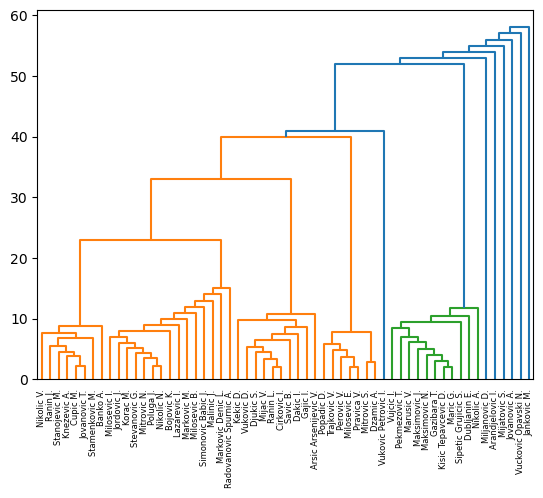

In [33]:
grivanNewman = nx.community.girvan_newman(G)

k = 6  # postavite željeni broj komuna
communities = list(sorted(c) for c in next(grivanNewman) if len(c) >= k)

# G = nx.path_graph(10)
communities = list(nx.community.girvan_newman(G))

# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format in @mdml's answer
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# also recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# also needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

# my function to get a merge height so that it is unique (probably not that efficient)
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

# finally using @mdml's magic, slightly modified:
G           = nx.DiGraph(node_id_to_children)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

# dendrogram
plt.figure()
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])

In [ ]:
# U gephi stavili 2.5 za Community Detection, za slucaj slican dendogramu

In [ ]:
# Importovanje potrebne biblioteke
from sklearn.cluster import SpectralClustering

# Definisanje broja klastera
n_clusters = 3

# Izračunavanje spektralnog klasterisanja
clustering = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", affinity="precomputed").fit(nx.adjacency_matrix(G).toarray())

colors = clustering.labels_
c_string = []
for c in colors:
    c_string.append(str(c))

spectral_clust_graph = nx.Graph()
for c, label in zip(c_string, G.nodes()):
    spectral_clust_graph.add_node(label, color=c)

for edge in G.edges(data=True):
    #print(edge)
    spectral_clust_graph.add_edge(edge[0], edge[1], weight=edge[2]['weight'])

nx.write_pajek(spectral_clust_graph, "models/spectral4.net")

csizes = np.zeros(n_clusters)
for c in colors:
    csizes[int(c)] += 1

print(f"Podela na {n_clusters}: velicine komponenata su {csizes}")